# Testing the Integrated Simulation Platform
This notebook contains codes to test the various functionalities of the integrated simulation platform. You can call any of the modules from the package here. 

In [132]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import required packages

In [133]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import time
import re
from numpy import random
import random as rand

from dreaminsg_integrated_model.network_sim_models.interdependencies import *
import dreaminsg_integrated_model.network_sim_models.water.water_network_model as water
import dreaminsg_integrated_model.network_sim_models.power.power_system_model as power
import dreaminsg_integrated_model.network_sim_models.transportation.network as transpo
from dreaminsg_integrated_model.data.disruptive_scenarios.disrupt_generator import *

import dreaminsg_integrated_model.results.figures.plots as plots

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

## Load the three infrastructure models: Water, Power and Transportation

In [157]:
MAIN_DIR = Path('..')
ABS_MAIN_DIR = os.path.abspath('..')

#load water_network model
water_folder = MAIN_DIR/'dreaminsg_integrated_model/data/networks/water'
wn = water.load_water_network(water_folder/'Example_water.inp')
total_base_water_demand = sum([wn.get_node(node).base_demand for node in wn.junction_name_list])

#load power systems network
power_folder = MAIN_DIR/'dreaminsg_integrated_model/data/networks/power'
pn = power.load_power_network(power_folder/'Example_power.json')
power.run_power_simulation(pn)
total_base_power_demand = pn.res_load.p_mw.sum() + pn.res_motor.p_mw.sum()
print(total_base_power_demand)

#load dynamic traffic assignment model
transp_folder = MAIN_DIR/'dreaminsg_integrated_model/data/networks/transportation/Example1'
tn = transpo.Network(
    "{}/example_net.tntp".format(transp_folder), 
    "{}/example_trips.tntp".format(transp_folder),
    "{}/example_node.tntp".format(transp_folder))
tn.userEquilibrium("FW", 400, 1e-4, tn.averageExcessCost)

Water network successfully loaded from ..\dreaminsg_integrated_model\data\networks\water\Example_water.inp. The analysis type is set to Pressure De[endent Demand Analysis.
Power system successfully loaded from ..\dreaminsg_integrated_model\data\networks\power\Example_power.json
3.8299999999999996
Iteration 1: gap 0.000305: time 0.000000
Iteration 2: gap 0.000000: time 0.004984


## Build interdependencies

In [148]:
net1_deps = DependencyTable()
net1_deps.add_pump_motor_coupling(water_id='WP1', power_id='MP1', motor_mw=pn.motor.pn_mech_mw[pn.motor.name == 'MP1'].values[0], pm_efficiency=1.0)
net1_deps.add_gen_reserv_coupling(water_id='R1', power_id='G3', gen_mw=1, gr_efficiency=1.0)
#net1_deps.wp_table

## Create a Networkx graph of the integrated infrastructure network.

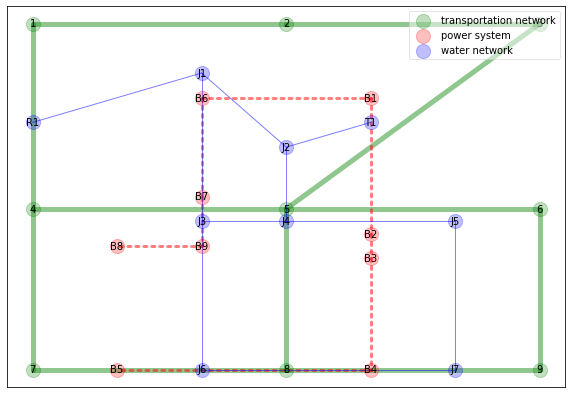

In [149]:
integrated_graph = plots.plot_integrated_network(pn, wn, tn)

In [150]:
net1_deps.add_transpo_access(integrated_graph)
net1_deps.access_table.head()

,origin_id,transp_id,origin_cat,origin_type,access_dist
0,B8,4,power,"(B, bus, Bus)",125.00
1,B7,5,power,"(B, bus, Bus)",103.08
2,B5,7,power,"(B, bus, Bus)",100.00
3,B4,8,power,"(B, bus, Bus)",100.00
4,B6,2,power,"(B, bus, Bus)",180.28


## Simulation of interdependent effects using a test scenario
### (a) Scheduling infrastructure diruptions and optimal recovery actions.

In [152]:
#Setting recovery parameters
curr_loc_crew = 8
recovery_rate = 0.05

#Setting simulation parameters
sim_duration = 60*100
sim_step = 60

# creating test case dataframe
scenario_file = '../dreaminsg_integrated_model/data/disruptive_scenarios/test1/motor_failure.csv'
motor_failure = DisruptionAndRecovery(scenario_file, sim_duration, sim_step, curr_loc_crew)

#Simulating repair curves
repair_order = motor_failure.optimze_recovery_strategy()
print("The optimsed repair stragegy is to shcedule repair of failed components in the following order: {}\n".format(repair_order))
for index, node in enumerate(repair_order):
    origin_node = node
    connected_bus = find_connected_power_node(origin_node, pn)
    nearest_node, near_dist = get_nearest_node(integrated_graph, connected_bus, "transpo_node")
    #print("The nearest node to {} is {} at a distance of {}m.".format(origin_node, nearest_node, near_dist))

    travel_time = int(round(tn.calculateShortestTravelTime(curr_loc_crew, nearest_node), 0))
    print("The crew is currently (at t = {} minutes) at node {}. It will take {} minutes to reach nearest node {}, the nearest transportation node from {}.".format(
        motor_failure.next_crew_trip_start/motor_failure.sim_step, motor_failure.curr_loc_crew, travel_time, nearest_node, node))
    recovery_start = motor_failure.next_crew_trip_start + travel_time*60

    #Schedule the recovery action
    recovery_start = motor_failure.next_crew_trip_start + travel_time*60
    motor_failure.schedule_recovery(origin_node, recovery_start, recovery_rate)

The optimsed repair stragegy is to shcedule repair of failed components in the following order: ['MP1', 'L4']

The crew is currently (at t = 10.0 minutes) at node 8. It will take 8 minutes to reach nearest node 4, the nearest transportation node from MP1.
The repair action at MP1 successfuly completed at time 52.0 minutes

The crew is currently (at t = 52.0 minutes) at node MP1. It will take 13 minutes to reach nearest node 2, the nearest transportation node from L4.
The repair action at L4 successfuly completed at time 82.0 minutes



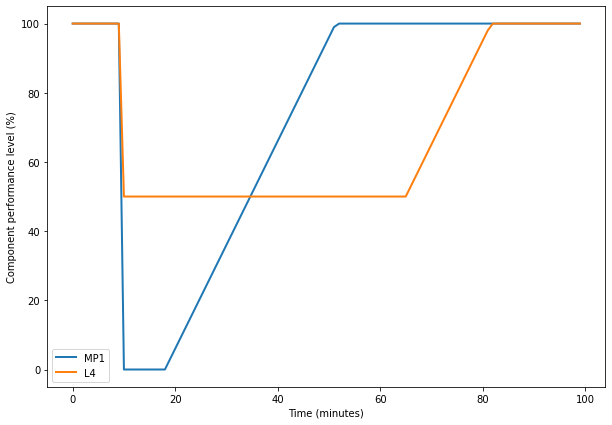

In [153]:
#Plotting repair curves
plots.plot_repair_curves(motor_failure)

### (b) Simulating the interdependent effects

In [158]:
power_consump_tracker = []
water_consump_tracker = []
time_tracker = []

#simulating the netwokwide impacts
for index, row in motor_failure.event_table.iterrows():
    #Update the operational level of directly affected components
    motor_failure.update_directly_affected_components(pn, wn, index)

    #run power systems model
    power.run_power_simulation(pn)
    #print(pn.load.p_mw.sum())
    #print(pn.motor.in_service.item())

    #Fix the time until which the wntr model should run in this iteration
    wn.options.time.duration = sim_step*(index)

    #set the pump power value based on motor power value
    net1_deps.update_dependencies(pn, wn)

    #run water distribution model and save current status
    wn_results = water.run_water_simulation(wn, sim_step)

    time_tracker.append(int(row['time_stamp']))
    power_consump_tracker.append((pn.res_load.p_mw.sum() + pn.res_motor.p_mw.sum())/total_base_power_demand)
    water_consump_tracker.append(sum([wn.get_node(node).demand for node in wn.junction_name_list])/total_base_water_demand)
    
    if index % 10 == 0:
        print("Iteration {} completed successfully".format(index))


Iteration 0 completed successfully
Iteration 10 completed successfully
Iteration 20 completed successfully
Iteration 30 completed successfully
Iteration 40 completed successfully
Iteration 50 completed successfully
Iteration 60 completed successfully
Iteration 70 completed successfully
Iteration 80 completed successfully
Iteration 90 completed successfully


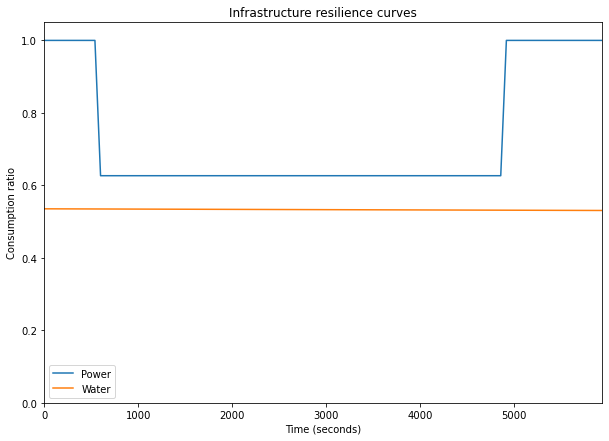

In [159]:
plots.plot_interdependent_effects(power_consump_tracker, water_consump_tracker, time_tracker)